# System Modelling

Author : Masuk  
Help   : Nishi

In [21]:
# Make sure lenstronomy is installed, otherwise install the latest pip version
import h5py  # library to work with '.h5' files
import matplotlib.pyplot as plt
import numpy as np
from lenstronomy.Data.coord_transforms import Coordinates
from lenstronomy.Plots.model_plot import ModelPlot
from lenstronomy.Util import mask_util, util
from lenstronomy.Workflow.fitting_sequence import FittingSequence
import joblib

try:
    pass
except ModuleNotFoundError:
    !pip install lenstronomy

## Import of standard python libraries

In [2]:
%matplotlib inline

## Load imaging and psf data

In [3]:
with h5py.File("./DESIJ1421-0022_F140W.h5", "r") as f:  # loading image data
    kwargs_data = {}
    for key in f:
        kwargs_data[key] = f[key][()]

kwargs_data

{'background_rms': 0.016322818764336215,
 'dec_at_xy_0': -5.639999999999994,
 'exposure_time': array([[392.5919 , 429.8496 , 477.49698, ..., 417.0545 , 626.3687 ,
         470.51013],
        [537.5037 , 481.4545 , 402.75043, ..., 445.28027, 411.41382,
         414.60626],
        [441.50906, 430.91473, 528.3243 , ..., 582.93396, 452.38983,
         456.0343 ],
        ...,
        [455.4104 , 487.22336, 492.4171 , ..., 564.8773 , 450.29538,
         395.7962 ],
        [509.2898 , 384.29117, 459.5256 , ..., 396.0305 , 487.2688 ,
         570.89014],
        [438.19513, 478.61502, 508.9901 , ..., 350.71753, 400.08707,
         430.7757 ]], dtype=float32),
 'image_data': array([[-0.00921469, -0.02078328,  0.00167325, ..., -0.0132964 ,
         -0.03175444, -0.01695797],
        [-0.00559985, -0.01327114, -0.00524183, ...,  0.00243682,
         -0.00851916, -0.01378721],
        [ 0.00427728, -0.00057159, -0.02292269, ..., -0.01166504,
         -0.00735005, -0.00661949],
        ...,
   

In [4]:
with h5py.File("./psf_F140W.h5", "r") as f:  # loading psf data
    kwargs_psf = {}
    for key in f:
        kwargs_psf[key] = f[key][()]

kwargs_psf["psf_type"] = "PIXEL"
kwargs_psf

{'kernel_point_source': array([[5.7422681e-06, 4.5087054e-06, 2.4900439e-06, ..., 1.8486933e-06,
         3.2385867e-06, 4.4331632e-06],
        [3.9503216e-06, 9.9817180e-06, 6.5966469e-06, ..., 3.9997908e-06,
         6.6143798e-06, 4.1430776e-06],
        [2.9697005e-06, 5.5563592e-06, 1.2795975e-05, ..., 7.8115263e-06,
         5.1404800e-06, 1.7530243e-06],
        ...,
        [1.6921831e-06, 3.7347368e-06, 7.6415899e-06, ..., 1.1465157e-05,
         5.3933368e-06, 1.6360833e-06],
        [2.8819463e-06, 6.2348781e-06, 4.7564718e-06, ..., 4.5906190e-06,
         8.7221979e-06, 3.7005334e-06],
        [3.7170516e-06, 3.6243027e-06, 1.6518559e-06, ..., 2.0127884e-06,
         3.2246478e-06, 5.1252514e-06]], dtype=float32),
 'psf_type': 'PIXEL'}

/tmp/ipykernel_21207/746742490.py:7: RuntimeWarning: invalid value encountered in log10
  axes[0].imshow(np.log10(image), origin="lower", cmap="cubehelix")
/tmp/ipykernel_21207/746742490.py:10: RuntimeWarning: invalid value encountered in log10
  axes[1].imshow(np.log10(image), origin="lower", cmap="cubehelix")


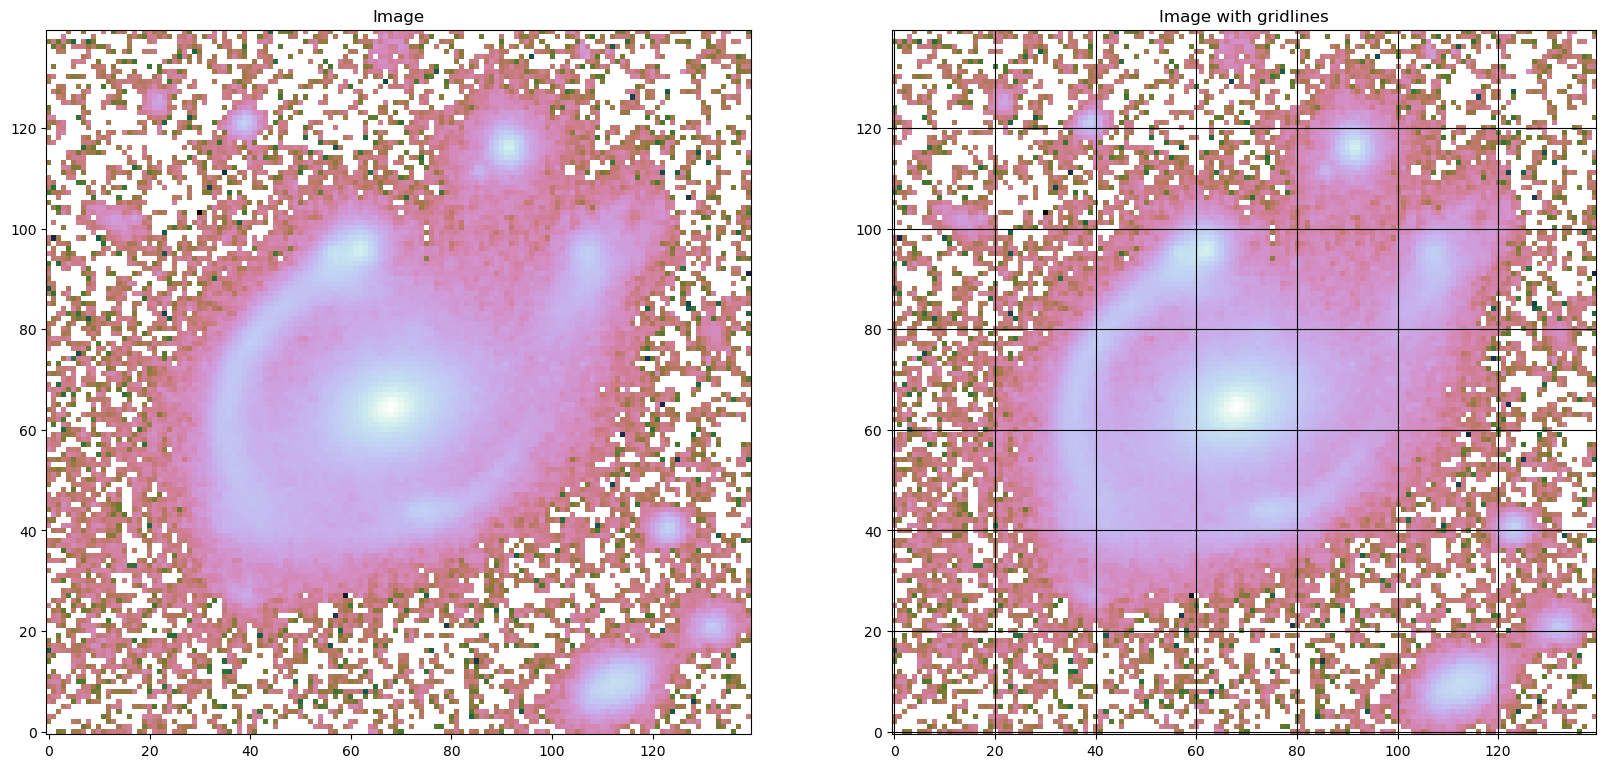

In [5]:
# extracting image_data from kwargs_data
image = kwargs_data["image_data"]

# Make the plot
fig, axes = plt.subplots(1, 2, figsize=(20, 20))

axes[0].imshow(np.log10(image), origin="lower", cmap="cubehelix")
axes[0].set_title("Image")

axes[1].imshow(np.log10(image), origin="lower", cmap="cubehelix")
axes[1].set_title("Image with gridlines")
axes[1].grid(True, color="black")

# Show the plots
plt.show()

## Masking

In [6]:
ra_at_xy_0 = kwargs_data["ra_at_xy_0"]
dec_at_xy_0 = kwargs_data["dec_at_xy_0"]
transform_pix2angle = kwargs_data["transform_pix2angle"]

coords = Coordinates(transform_pix2angle, ra_at_xy_0, dec_at_xy_0)
num_pix = len(image)

x_coords, y_coords = coords.coordinate_grid(num_pix, num_pix)

a = 5.5  # arcsecond (0.8 arcsec = 10 pix)
b = 4.7
lens_center_ra = 0
lens_center_dec = 0

mask_outer = mask_util.mask_ellipse(
    util.image2array(x_coords),
    util.image2array(y_coords),
    lens_center_ra,
    lens_center_dec,
    a,
    b,
    -np.pi / 4,
)

# 11 o' clock
mask_ext1 = mask_util.mask_ellipse(
    util.image2array(x_coords),
    util.image2array(y_coords),
    lens_center_ra + 0.8,
    lens_center_dec + 2,
    0.7,
    0.5,
    -np.pi / 6,
)

# mask_ext1 = mask_util.mask_center_2d(lens_center_ra+0.8,
#                                       lens_center_dec+2.1,
#                                       0.5,
#                                       util.image2array(x_coords),
#                                       util.image2array(y_coords))


# 1 o' clock
mask_ext2 = mask_util.mask_ellipse(
    util.image2array(x_coords),
    util.image2array(y_coords),
    lens_center_ra - 1.6,
    lens_center_dec + 3.6,
    0.7,
    0.5,
    -np.pi / 6,
)


# mask_ext2 = mask_util.mask_center_2d(lens_center_ra-1.6,
#                                       lens_center_dec+3.7,
#                                       0.5,
#                                       util.image2array(x_coords),
#                                       util.image2array(y_coords))


# 2 o' clock

mask_ext3 = mask_util.mask_ellipse(
    util.image2array(x_coords),
    util.image2array(y_coords),
    lens_center_ra - 2.9,
    lens_center_dec + 1.8,
    0.7,
    0.5,
    -np.pi / 3,
)

# mask_ext3 = mask_util.mask_center_2d(lens_center_ra-2.9,
#                                       lens_center_dec+1.8,
#                                       0.4,
#                                       util.image2array(x_coords),
#                                       util.image2array(y_coords))


# 5 o' clock

mask_ext4 = mask_util.mask_ellipse(
    util.image2array(x_coords),
    util.image2array(y_coords),
    lens_center_ra - 0.5,
    lens_center_dec - 2.1,
    0.6,
    0.3,
    0,
)

# mask_ext4 = mask_util.mask_center_2d(lens_center_ra-0.5,
#                                       lens_center_dec-2.1,
#                                       0.3,
#                                       util.image2array(x_coords),
#                                       util.image2array(y_coords))


# 7 o' clock
mask_ext5 = mask_util.mask_center_2d(
    lens_center_ra + 2.5,
    lens_center_dec - 3.4,
    0.4,
    util.image2array(x_coords),
    util.image2array(y_coords),
)


mask = mask_outer * (1 - mask_ext2)
mask = mask * mask_ext5
# mask = mask * (1-mask_ext3)
mask[mask >= 1] = 1
mask[mask < 0] = 0

/tmp/ipykernel_21207/3723066894.py:4: RuntimeWarning: invalid value encountered in log10
  axes[0].imshow(np.log10(image), origin="lower", cmap="cubehelix")
/tmp/ipykernel_21207/3723066894.py:14: RuntimeWarning: divide by zero encountered in log10
  image_after_mask = np.log10(image * mask)
/tmp/ipykernel_21207/3723066894.py:14: RuntimeWarning: invalid value encountered in log10
  image_after_mask = np.log10(image * mask)


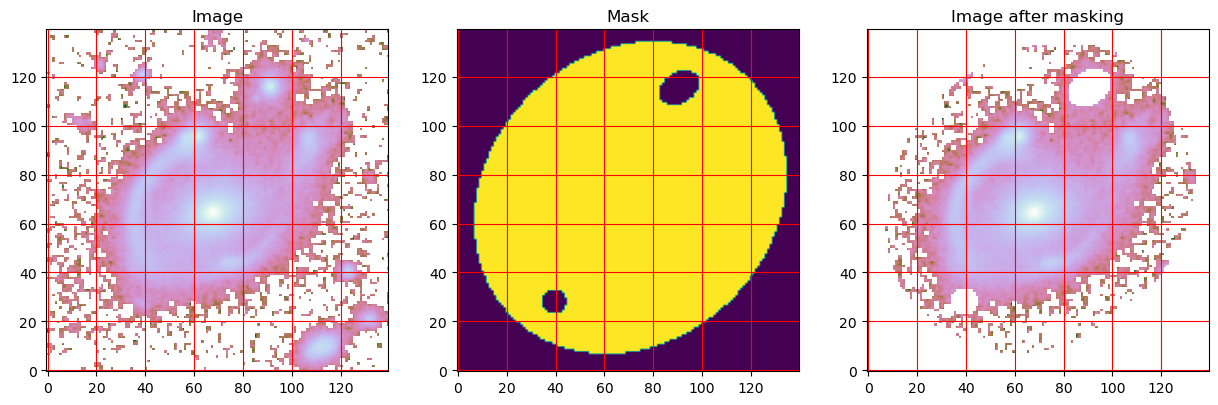

In [7]:
# Setting the subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 15))

axes[0].imshow(np.log10(image), origin="lower", cmap="cubehelix")
axes[0].grid(True, color="red")
axes[0].set_title("Image")

mask = mask.reshape(num_pix, num_pix)

axes[1].imshow(mask, origin="lower")
axes[1].grid(True, color="red")
axes[1].set_title("Mask")

image_after_mask = np.log10(image * mask)

axes[2].imshow(image_after_mask, origin="lower", cmap="cubehelix")
axes[2].grid(True, color="red")
axes[2].set_title("Image after masking")


# Show the plots
plt.show()

## Building a lens model

In [8]:
# adding shear into lens_model_list
lens_model_list = ["EPL", "SHEAR_GAMMA_PSI"]
# adding shapelets into source_model_list
source_model_list = ["SERSIC_ELLIPSE", "SHAPELETS"]
lens_light_model_list = ["SERSIC_ELLIPSE", "SERSIC_ELLIPSE"]

### Lens galaxy's mass model

In [9]:
fixed_lens = []
kwargs_lens_init = []
kwargs_lens_sigma = []
kwargs_lower_lens = []
kwargs_upper_lens = []

fixed_lens.append({})

fixed_lens.append({"ra_0": 0, "dec_0": 0})


# EPL
kwargs_lens_init.append(
    {
        "theta_E": 1.8,
        "gamma": 2,
        "e1": 0.137,
        "e2": -0.331,
        "center_x": 0.336,
        "center_y": -0.324,
    }
)

kwargs_lens_sigma.append(
    {
        "theta_E": 0.01,
        "gamma": 0.01,
        "e1": 0.05,
        "e2": 0.05,
        "center_x": 0.5,
        "center_y": 0.5,
    }
)

kwargs_lower_lens.append(
    {
        "theta_E": 1.3,
        "gamma": 1.7,
        "e1": 0.10,
        "e2": -0.4,
        "center_x": -10,
        "center_y": -10,
    }
)

kwargs_upper_lens.append(
    {
        "theta_E": 1.9,
        "gamma": 2.2,
        "e1": 0.14,
        "e2": -0.2,
        "center_x": 10,
        "center_y": 10,
    }
)


# SHEAR
fixed_lens.append(
    {
        "ra_0": 0,
        "dec_0": 0,
    }
)
kwargs_lens_init.append({"gamma_ext": 0.324, "psi_ext": -0.8849, "ra_0": 0, "dec_0": 0})
kwargs_lens_sigma.append({"gamma_ext": 0.05, "psi_ext": 0.1, "ra_0": 0, "dec_0": 0})
kwargs_lower_lens.append(
    {"gamma_ext": 0, "psi_ext": -np.pi / 2, "ra_0": -100, "dec_0": -100}
)
kwargs_upper_lens.append(
    {"gamma_ext": 0.4, "psi_ext": np.pi / 2, "ra_0": 100, "dec_0": 100}
)
lens_params = [
    kwargs_lens_init,
    kwargs_lens_sigma,
    fixed_lens,
    kwargs_lower_lens,
    kwargs_upper_lens,
]

### Lens galaxy's light model

In [15]:
fixed_lens_light = []
kwargs_lens_light_init = []
kwargs_lens_light_sigma = []
kwargs_lower_lens_light = []
kwargs_upper_lens_light = []

# 1st Sersic profile. lens galaxy's light model
fixed_lens_light.append({"n_sersic": 4.0})


kwargs_lens_light_init.append(
    {
        "R_sersic": 0.399,
        "n_sersic": 2,
        "e1": -0.0355,
        "e2": -0.1492,
        "center_x": 0.2,
        "center_y": -0.48,
        "amp": 1,
    }
)

kwargs_lens_light_sigma.append(
    {
        "n_sersic": 1,
        "R_sersic": 0.3,
        "e1": 0.05,
        "e2": 0.05,
        "center_x": 0.1,
        "center_y": 0.1,
        "amp": 10,
    }
)

kwargs_lower_lens_light.append(
    {
        "e1": -0.5,
        "e2": -0.5,
        "R_sersic": 0.2,
        "n_sersic": 0.5,
        "center_x": -10,
        "center_y": -10,
        "amp": 0,
    }
)

kwargs_upper_lens_light.append(
    {
        "e1": 0.5,
        "e2": 0.5,
        "R_sersic": 0.4,
        "n_sersic": 5.0,
        "center_x": 10,
        "center_y": 10,
        "amp": 100,
    }
)


# 2nd Sersic profile. lens galaxy's light model
fixed_lens_light.append({"n_sersic": 4.0})

kwargs_lens_light_init.append(
    {
        "R_sersic": 0.11,
        "n_sersic": 2,
        "e1": 0,
        "e2": 0,
        "center_x": 0.0,
        "center_y": 0,
        "amp": 1,
    }
)

kwargs_lens_light_sigma.append(
    {
        "n_sersic": 1,
        "R_sersic": 0.01,
        "e1": 0.05,
        "e2": 0.05,
        "center_x": 0.1,
        "center_y": 0.1,
        "amp": 10,
    }
)

kwargs_lower_lens_light.append(
    {
        "e1": -0.5,
        "e2": -0.5,
        "R_sersic": 0.10,
        "n_sersic": 0.5,
        "center_x": -10,
        "center_y": -10,
        "amp": 0,
    }
)

kwargs_upper_lens_light.append(
    {
        "e1": 0.5,
        "e2": 0.5,
        "R_sersic": 0.14,
        "n_sersic": 5.0,
        "center_x": 10,
        "center_y": 10,
        "amp": 100,
    }
)

joint_lens_with_light = [[0, 0, ["center_x", "center_y", "e1", "e2"]]]

joint_lens_light_with_lens_light = [[0, 1, ["center_x", "center_y"]]]

lens_light_params = [
    kwargs_lens_light_init,
    kwargs_lens_light_sigma,
    fixed_lens_light,
    kwargs_lower_lens_light,
    kwargs_upper_lens_light,
]

### Source galaxy's light model

In [16]:
fixed_source = []
kwargs_source_init = []
kwargs_source_sigma = []
kwargs_lower_source = []
kwargs_upper_source = []

fixed_source.append({"n_sersic": 1.0})

kwargs_source_init.append(
    {
        "R_sersic": 0.2,
        "n_sersic": 1,
        "e1": 0,
        "e2": 0,
        "center_x": 0.0,
        "center_y": 0,
        "amp": 5,
    }
)

kwargs_source_sigma.append(
    {
        "n_sersic": 0.5,
        "R_sersic": 0.01,
        "e1": 0.05,
        "e2": 0.05,
        "center_x": 0.2,
        "center_y": 0.2,
        "amp": 10,
    }
)

kwargs_lower_source.append(
    {
        "e1": -0.5,
        "e2": -0.5,
        "R_sersic": 0.001,
        "n_sersic": 0.5,
        "center_x": -10,
        "center_y": -10,
        "amp": 0,
    }
)

kwargs_upper_source.append(
    {
        "e1": 0.5,
        "e2": 0.5,
        "R_sersic": 10,
        "n_sersic": 5.0,
        "center_x": 10,
        "center_y": 10,
        "amp": 100,
    }
)


fixed_source.append({"n_max": 5})

kwargs_source_init.append({"beta": 0.1, "n_max": 7, "center_x": 0.0, "center_y": 0.0})

kwargs_source_sigma.append(
    {"beta": 0.001, "n_max": 0.1, "center_x": 0.2, "center_y": 0.2}
)

kwargs_lower_source.append({"beta": 0.02, "n_max": 2, "center_x": -10, "center_y": -10})

kwargs_upper_source.append({"beta": 0.14, "n_max": 8, "center_x": 10, "center_y": 10})


joint_centroid = [[0, 1, ["center_x", "center_y"]]]


source_params = [
    kwargs_source_init,
    kwargs_source_sigma,
    fixed_source,
    kwargs_lower_source,
    kwargs_upper_source,
]

### Combining all the above specification in the `kwargs_params` dictionary

In [17]:
kwargs_params = {
    "lens_model": lens_params,
    "source_model": source_params,
    "lens_light_model": lens_light_params,
}

kwargs_constraints = {
    "joint_lens_light_with_lens_light": joint_lens_light_with_lens_light,
    # "joint_lens_with_light": joint_lens_with_light,
    "joint_source_with_source": joint_centroid,
}

### Numerical settings

In [18]:
kwargs_likelihood = {
    "check_bounds": True,
    "image_likelihood_mask_list": [mask],
    "check_positive_flux": True,
}

# Oversample the image plane by 2 when computing
# the lensed image for better accuracy
kwargs_numerics = {"supersampling_factor": 3, "supersampling_convolution": False}

### Combining all the information to be sent to lenstronomy

In [19]:
kwargs_model = {
    "lens_model_list": lens_model_list,
    "source_light_model_list": source_model_list,
    "lens_light_model_list": lens_light_model_list,
}

multi_band_list = [[kwargs_data, kwargs_psf, kwargs_numerics]]

kwargs_data_joint = {
    "multi_band_list": multi_band_list,
    "multi_band_type": "single-band",
}

## Here the model fitting is done

In [20]:
# using Particle Swarm Optimization
fitting_kwargs_list = [
    ["update_settings", {"lens_add_fixed": [[0, ["gamma"], [2]]]}],
    ["PSO", {"sigma_scale": 1.0, "n_particles": 100, "n_iterations": 500}],
]
# ['MCMC', {'n_burn': 200, 'n_run': 600, 'n_walkers':
# 200, 'sigma_scale': .1}]

# fitting_kwargs_list = [['PSO', {'sigma_scale': 1., 'n_particles': 200,
#                                 'n_iterations': 100}],
#                       ]


fitting_seq = FittingSequence(
    kwargs_data_joint,
    kwargs_model,
    kwargs_constraints,
    kwargs_likelihood,
    kwargs_params,
    mpi=False,
    verbose=True,
)

input = [
    fitting_kwargs_list,
    multi_band_list,
    kwargs_model,
    kwargs_constraints,
    kwargs_likelihood,
    kwargs_params,
]

fit_output = fitting_seq.fit_sequence(fitting_kwargs_list)
kwargs_result = fitting_seq.best_fit(bijective=False)
multi_band_list_out = fitting_seq.multi_band_list

kwargs_fixed_out = fitting_seq._updateManager.fixed_kwargs
output = [
    kwargs_result,
    multi_band_list_out,
    fit_output,
    kwargs_fixed_out,
]


# chain_list = fitting_seq.fit_sequence(fitting_kwargs_list)
# kwargs_result = fitting_seq.best_fit(bijective=False)

Computing the PSO ...
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
Max iteration reached! Stopping.
-16121.498097500473 reduced X^2 of best position
-100041956.44403918 log likelihood
12411 effective number of data points
[{'theta_E': 1.8090197871181417, 'gamma': 2, 'e1': 0.1387581959689497, 'e2': -0.39999665191199835, 'center_x': 0.21560978930190428, 'center_y': -0.501197889145312}, {'gamma_ext': 0.37671146886056905, 'psi_ext': -0.9408871342684549, 'ra_0': 0, 'dec_0': 0}] lens result
[{'amp': 1, 'R_sersic': 1.2877198699824937, 'n_sersic': 1.0, 'e1': 0.4999917442461484, 'e2': 0.38263681906179736, 'center_x': 0.950280722754567, 'center_y': 0.16237779801257468}, {'amp': 1, 'n_max': 5, 'beta': 0.10009144754157608, 'center_x': 0.950280722754567, 'center_y': 0.16237779801257468}] source result
[{'amp': 1, 'R_sersic': 0.3999698482410169, 'n_sersic'

## Saving the output file

In [24]:
output_path = "./DESIJ1421_0022_pso_output.joblib"

with open(output_path, "wb") as f:
    joblib.dump([input, output], f, compress=True)

## Visualizing the fitted model

{'kwargs_lens': [{'theta_E': 1.8090197871181417, 'gamma': 2, 'e1': 0.1387581959689497, 'e2': -0.39999665191199835, 'center_x': 0.21560978930190428, 'center_y': -0.501197889145312}, {'gamma_ext': 0.37671146886056905, 'psi_ext': -0.9408871342684549, 'ra_0': 0, 'dec_0': 0}], 'kwargs_source': [{'amp': 4.61889179682029, 'R_sersic': 1.2877198699824937, 'n_sersic': 1.0, 'e1': 0.4999917442461484, 'e2': 0.38263681906179736, 'center_x': 0.950280722754567, 'center_y': 0.16237779801257468}, {'amp': array([ 425.04664606, -241.79300468,  272.5932016 ,  269.58451184,
        -82.39791197,  276.79764448,  -56.03537206,   39.25783586,
         80.89125128,  209.24634564,  162.68599483,  119.10455521,
        117.37734396,  150.88817844,  177.52782485,  190.0637755 ,
       -146.06478304,  -24.12311351,  -44.9533907 ,  138.59942626,
        -32.02325241]), 'n_max': 5, 'beta': 0.10009144754157608, 'center_x': 0.950280722754567, 'center_y': 0.16237779801257468}], 'kwargs_lens_light': [{'amp': 316.55343485

/home/zareef/anaconda3/envs/lens/lib/python3.10/site-packages/lenstronomy/Plots/model_band_plot.py:63: RuntimeWarning: divide by zero encountered in log10
  log_model = np.log10(model)
/home/zareef/anaconda3/envs/lens/lib/python3.10/site-packages/lenstronomy/Plots/plot_util.py:367: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("cubehelix").copy()
  cmap_new.set_bad(color="k", alpha=1.0)
/home/zareef/anaconda3/envs/lens/lib/python3.10/site-packages/lenstronomy/Plots/plot_util.py:368: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap fi

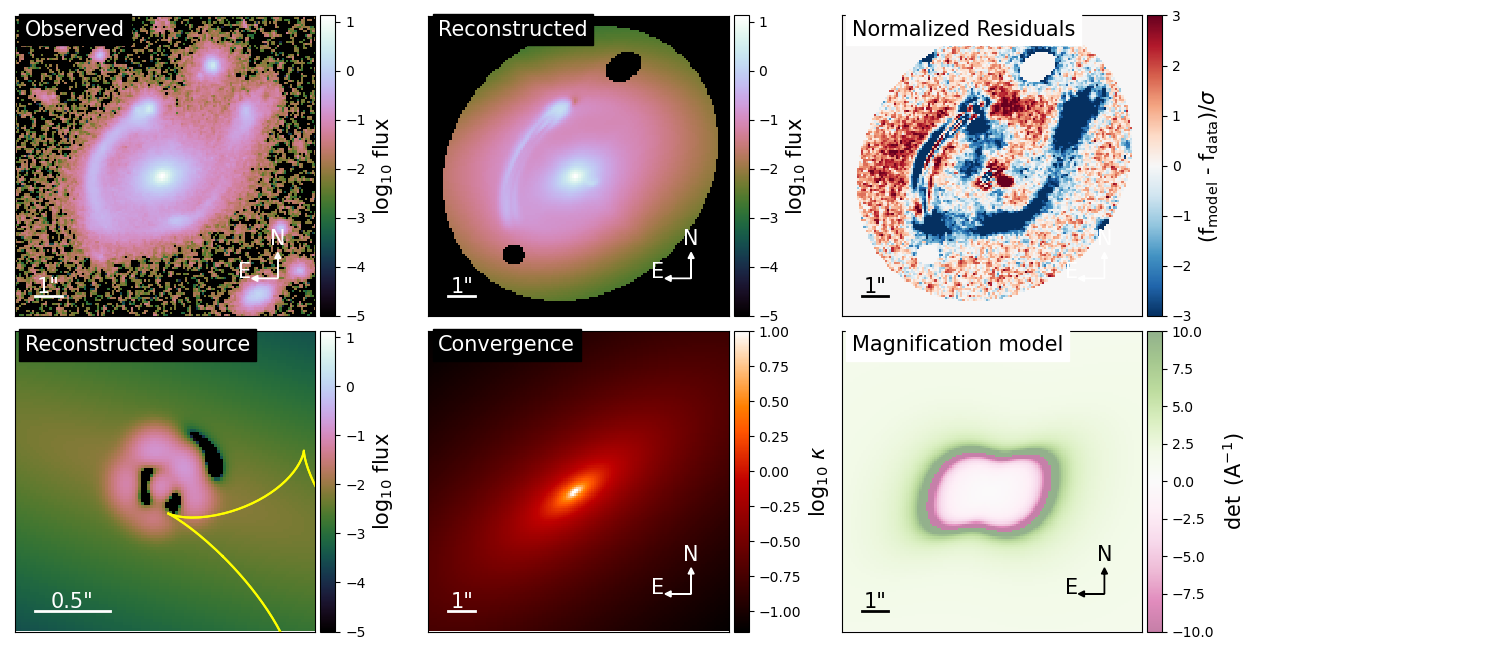

/home/zareef/anaconda3/envs/lens/lib/python3.10/site-packages/lenstronomy/Plots/model_band_plot.py:1062: RuntimeWarning: invalid value encountered in log10
  np.log10(model),


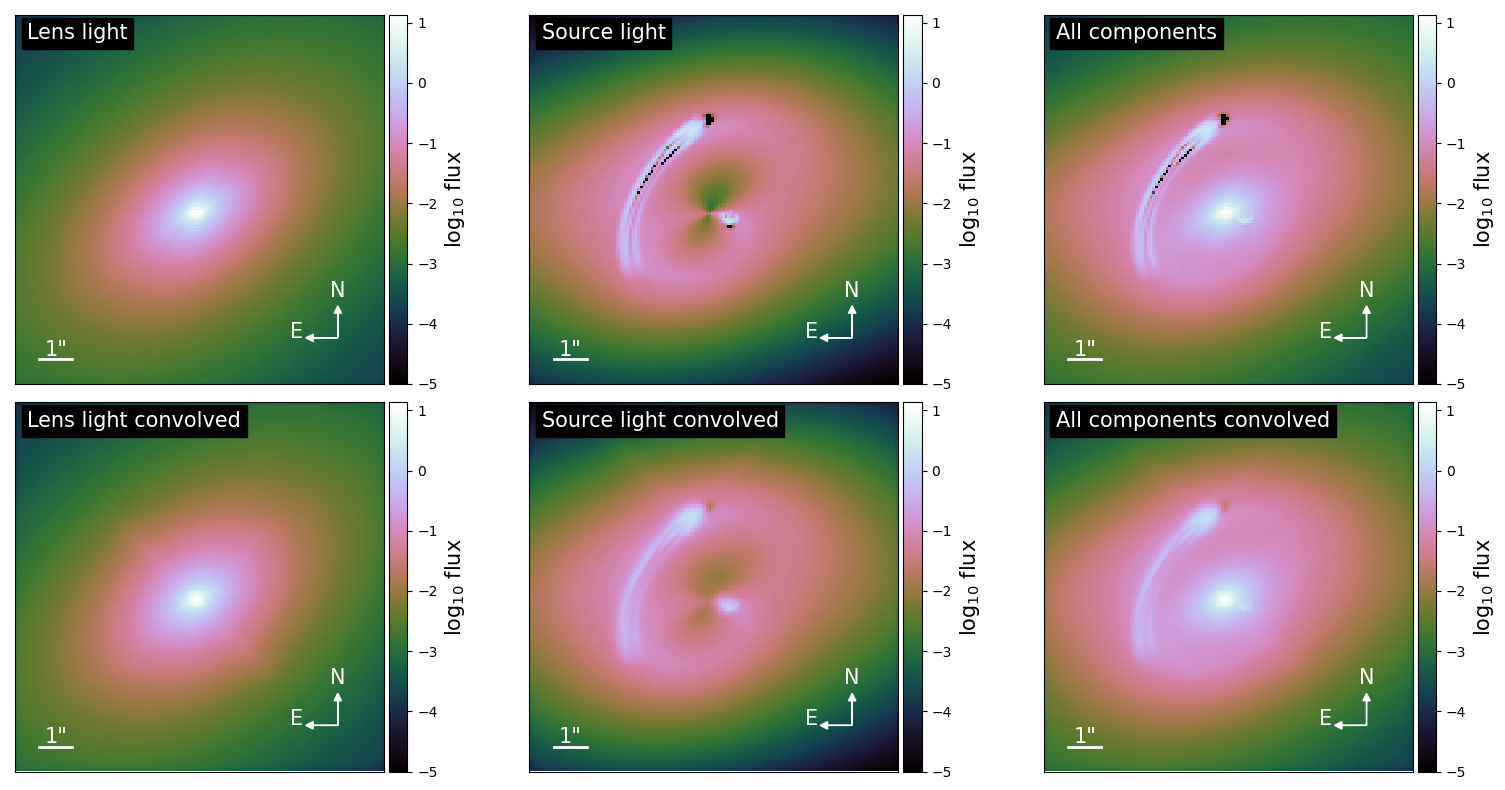

In [25]:
print(kwargs_result)
model_plot = ModelPlot(
    multi_band_list,
    kwargs_model,
    kwargs_result,
    arrow_size=0.02,
    cmap_string="cubehelix",
    image_likelihood_mask_list=kwargs_likelihood["image_likelihood_mask_list"],
)
f, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=False, sharey=False)

model_plot.data_plot(ax=axes[0, 0])
model_plot.model_plot(ax=axes[0, 1])
model_plot.normalized_residual_plot(ax=axes[0, 2], v_min=-3, v_max=3, cmap="RdBu_r")
model_plot.source_plot(
    ax=axes[1, 0],
    deltaPix_source=0.02,
    numPix=100,
    scale_size=0.5,
    with_caustics=True,
)
model_plot.convergence_plot(ax=axes[1, 1], v_max=1, cmap="gist_heat")
model_plot.magnification_plot(ax=axes[1, 2], cmap="PiYG")
f.tight_layout()
f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.0, hspace=0.05)
plt.show()

f, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=False, sharey=False)

model_plot.decomposition_plot(
    ax=axes[0, 0], text="Lens light", lens_light_add=True, unconvolved=True
)
model_plot.decomposition_plot(
    ax=axes[1, 0], text="Lens light convolved", lens_light_add=True
)
model_plot.decomposition_plot(
    ax=axes[0, 1], text="Source light", source_add=True, unconvolved=True
)
model_plot.decomposition_plot(
    ax=axes[1, 1], text="Source light convolved", source_add=True
)
model_plot.decomposition_plot(
    ax=axes[0, 2],
    text="All components",
    source_add=True,
    lens_light_add=True,
    unconvolved=True,
)
model_plot.decomposition_plot(
    ax=axes[1, 2],
    text="All components convolved",
    source_add=True,
    lens_light_add=True,
    point_source_add=True,
)
f.tight_layout()
f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.0, hspace=0.05)
plt.show()